<a href="https://colab.research.google.com/github/torigrosskopf/deep-learning/blob/main/mini_project_3_glioma_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Glioma classification

This notebook demonstrates classification of brain tumors with MONAI. To accelerate training, 2D dataset is used based on the 3D one.

## Notebook structure

Here's a rough outline of this notebook:

1. Check MONAI is installed and install if not (plus any extra dependencies)
1. Import libraries
1. Set up the data (download or create)
1. Prepare for training -- create transforms, datasets, dataloaders
1. Do some quick visualisations
1. Create our model, loss function, etc.
1. Train 🎉🥳🎊
1. Check results

## Dataset

The dataset used here is the Decathlon 3D brain tumor dataset. We generate a 2D dataset by combining slices containing tumour, and those containing no tumourous voxels (considered healthy).

<p align="center">
  <img src="https://github.com/Project-MONAI/GliMR_workshop/blob/main/figs/decathlon_brain_tumour_2d.png?raw=1" alt="Example of Decathlon brain tumour image">
</p>




## 1. Check MONAI is installed

This checks if MONAI is installed, and if not installs it (plus any optional extras that might be needed for this notebook).

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import gdown" || pip install -q "gdown"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.3 MB/s eta 0:00:00


## 2. Import libraries

In [4]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import torch
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

monai.config.print_config()

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=42)

MONAI version: 1.5.dev2446
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 218216250ce297265400abe56ee915898d75a2ec
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.66.6
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

In [5]:
# figure out if we're running in Google Colab. Set paths accordingly.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    best_model_folder = "/content/drive/MyDrive/saved_models/"
    os.makedirs(best_model_folder, exist_ok=True)
except:
    best_model_folder = ""

best_model_path = os.path.join(best_model_folder, "best_model_2d_glioma_classification.pth")

Mounted at /content/drive


## 3. Setup data

Specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  


### 2D data

Download the pre-computed dataset from Google Drive.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/tmp/tmptpqdehan


In [7]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images
images_healthy = glob(os.path.join(output_dir, "image_healthy", "*.nii.gz"))
images_tumour = glob(os.path.join(output_dir, "image_tumour", "*.nii.gz"))
data_dicts = []
data_dicts += [{"image": i, "label": [1, 0]} for i in images_healthy]
data_dicts += [{"image": i, "label": [0, 1]} for i in images_tumour]

# shuffle the data and sort into training and validation
train_files, val_files = partition_dataset(data_dicts, ratios=(8, 2), shuffle=True)
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

Downloading...
From (original): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E
From (redirected): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&confirm=t&uuid=63fb7a8e-7efd-4a4d-be75-c696a0e32654
To: /tmp/tmp0c2gk9c2/Task01_BrainTumour2D.tar
100%|██████████| 122M/122M [00:03<00:00, 32.8MB/s]

2024-11-21 22:31:44,561 - INFO - Downloaded: /tmp/tmptpqdehan/Task01_BrainTumour2D.tar


2024-11-21 22:31:44,803 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2024-11-21 22:31:44,805 - INFO - Writing into directory: /tmp/tmptpqdehan.
total num files: 968
num training files: 774
num validation files: 194


### 4. Create Transforms, Datasets, and Dataloaders

In [8]:
train_transforms = val_transforms = mt.Compose(
    [
        mt.LoadImaged("image"),
        mt.Rotate90d("image"),
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` was changed in version 1.5 from `allow_smaller=True` to `allow_smaller=False`.
  warn_deprecated(argname, msg, warning_category)


In [9]:
# The cache dataset loads in our images and keeps them in the RAM to save time on each loop.
# We use the pad_list_data_collate so that all images in our batch of data are the same size.
num_workers = 2
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=10,
                          num_workers=num_workers, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=10,
                        num_workers=num_workers, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 194/194 [00:03<00:00, 60.15it/s]


## 5. Display some examples

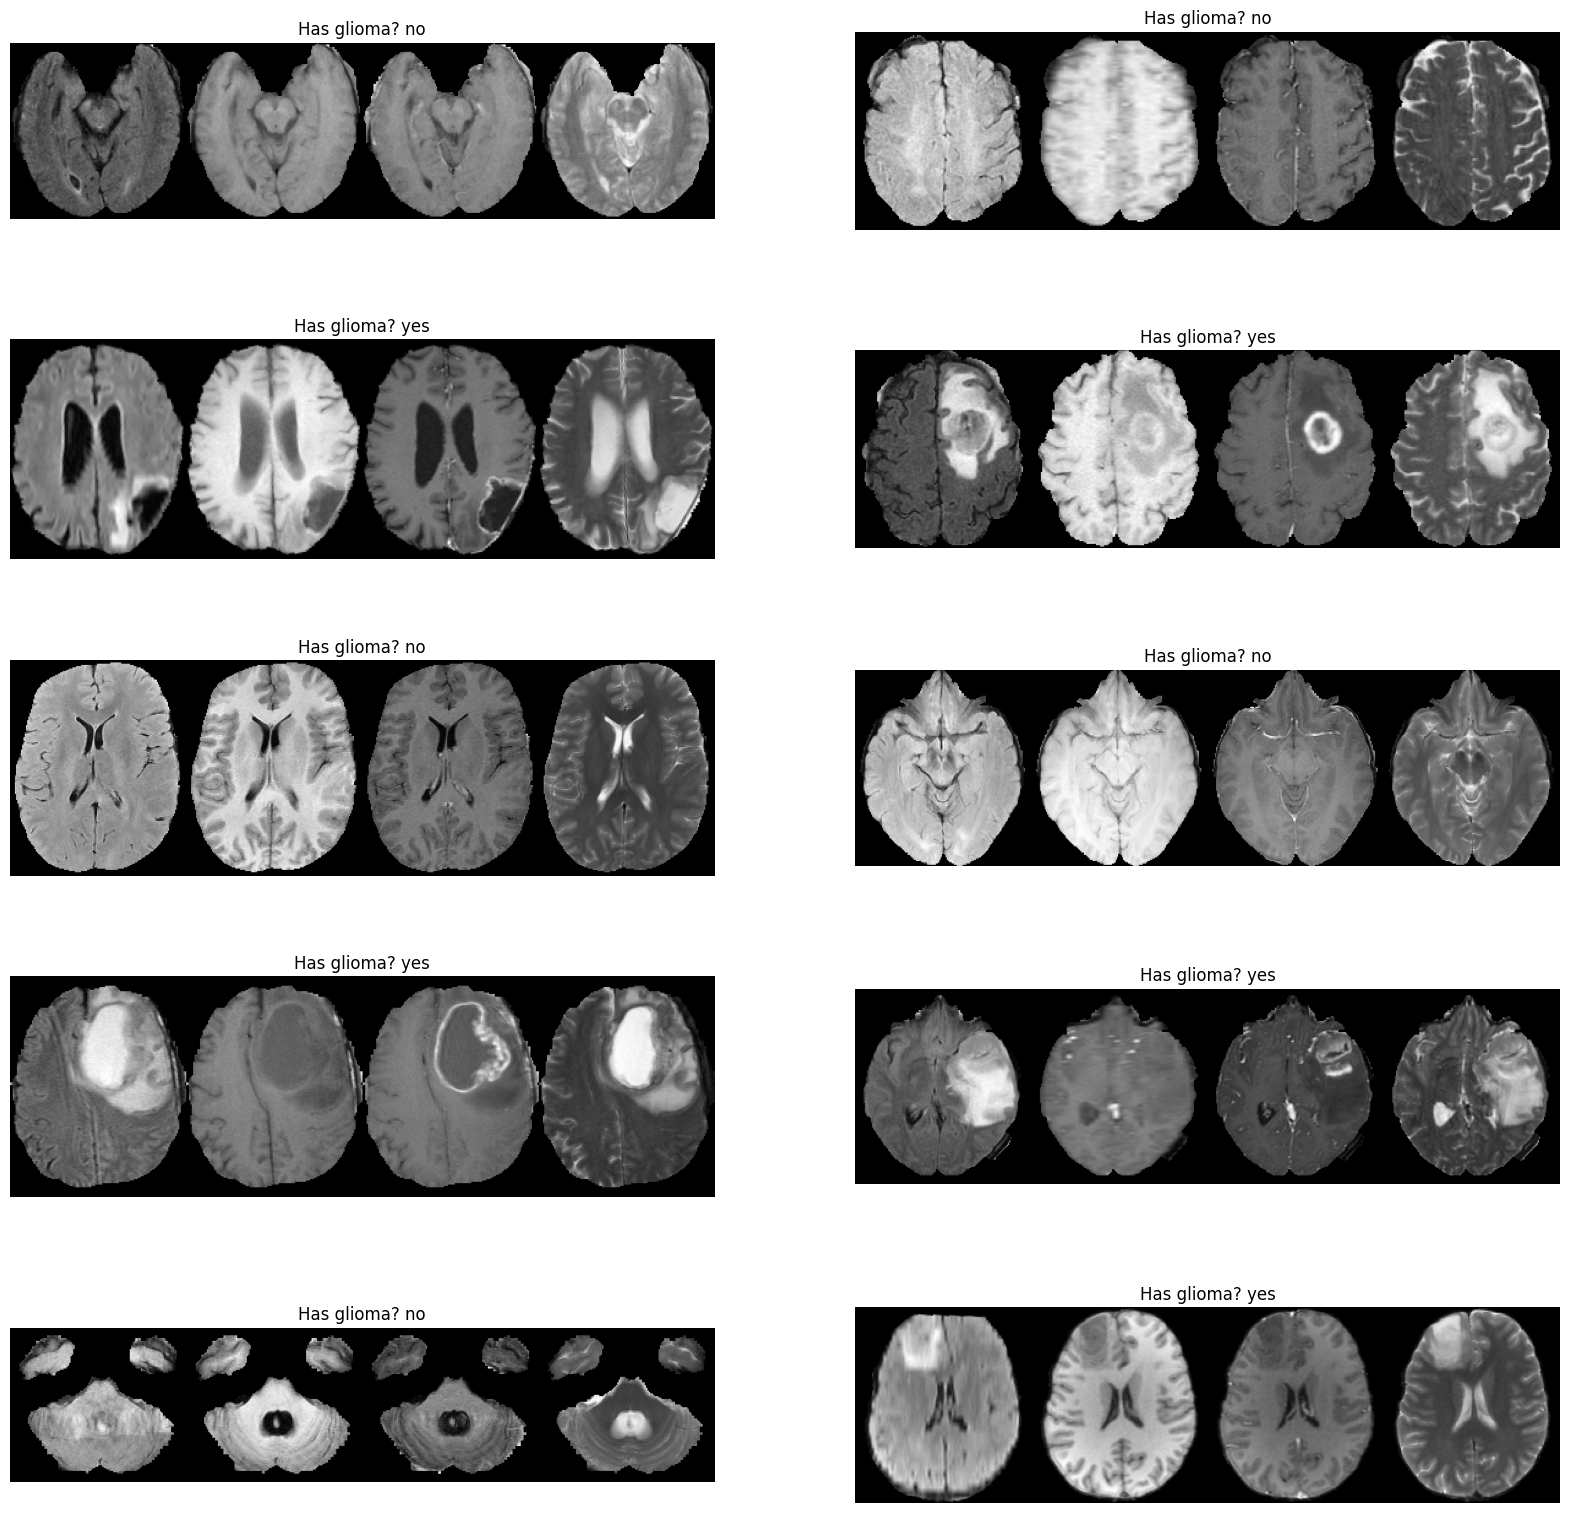

In [10]:
nrow, ncol = 5, 2
num_files = nrow * ncol
files_to_visualize = np.random.choice(train_files, size=num_files, replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20), facecolor='white')
for f, ax in zip(files_to_visualize, axes.flatten()):
    data = train_transforms(f)
    # different modalities side by side
    img = np.concatenate(list(data["image"]), axis=1)
    im_show = ax.imshow(img, cmap="gray")
    ax.set_title(f"Has glioma? {['yes', 'no'][data['label'][0]]}")
    ax.axis("off")

## 6. Create the model, loss function, etc.


In [12]:
# Define Models
model_1 = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)

model_2 = monai.networks.nets.DenseNet169(spatial_dims=2, in_channels=4, out_channels=2)

model_3 = monai.networks.nets.DenseNet264(spatial_dims=2, in_channels=4, out_channels=2)

model_1.to(device)
model_2.to(device)
model_3.to(device)

# Insert your loss function here
loss_function = torch.nn.CrossEntropyLoss()

In [13]:
# Helper function for inferring during validation for each model
def infer_seg(images, model_1):
    return model_1(images).argmax(0)

def infer_seg(images, model_2):
    return model_2(images).argmax(0)

def infer_seg(images, model_3):
    return model_3(images).argmax(0)

# use Adam optimizer for each model
optimizer_1 = torch.optim.Adam(model_1.parameters(), 1e-3)

optimizer_2 = torch.optim.Adam(model_2.parameters(), 1e-3)

optimizer_3 = torch.optim.Adam(model_3.parameters(), 1e-3)

# 7. Train!

In [15]:
# MODEL 1

# start a typical PyTorch training
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_1.zero_grad()
        outputs = model_1(inputs)
        outputs = torch.nn.Softmax(dim=1)(outputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer_1.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model_1):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model_1(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model_1.state_dict(), best_model_path)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.4227, best val metric: 0.9227 at epoch 10: 100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


Text(0.5, 1.0, 'Model 1')

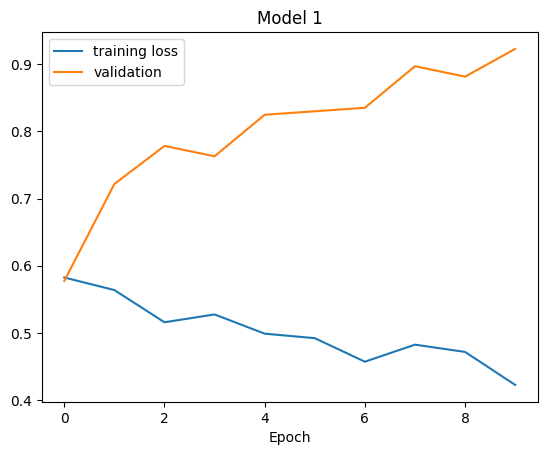

In [17]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()
plt.title("Model 1")

In [18]:
model_1.load_state_dict(torch.load(best_model_path))
_ = model_1.eval()

<ipython-input-18-7a5597aac6e4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(best_model_path))


In [20]:
# MODEL 2

# start a typical PyTorch training
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_2.zero_grad()
        outputs = model_2(inputs)
        outputs = torch.nn.Softmax(dim=1)(outputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer_2.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model_2):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model_2(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model_2.state_dict(), best_model_path)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.4173, best val metric: 0.9485 at epoch 8: 100%|██████████| 10/10 [03:41<00:00, 22.18s/it]


Text(0.5, 1.0, 'Model 2')

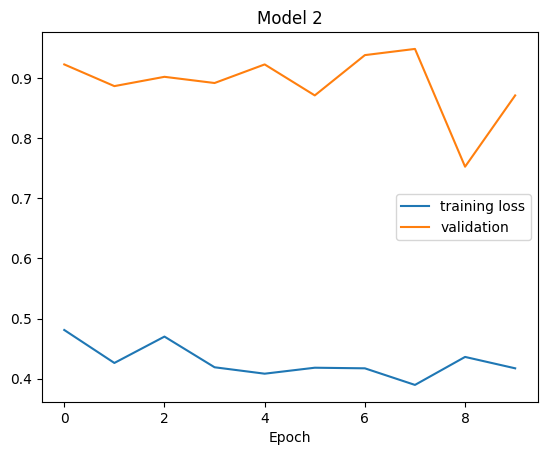

In [22]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()
plt.title("Model 2")

In [23]:
model_2.load_state_dict(torch.load(best_model_path))
_ = model_2.eval()

<ipython-input-23-1a46da4fcffd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load(best_model_path))


In [24]:
# MODEL 3

# start a typical PyTorch training
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_3.zero_grad()
        outputs = model_3(inputs)
        outputs = torch.nn.Softmax(dim=1)(outputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer_3.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model_3):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model_3(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model_3.state_dict(), best_model_path)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.4402, best val metric: 0.9433 at epoch 10: 100%|██████████| 10/10 [05:28<00:00, 32.82s/it]


Text(0.5, 1.0, 'Model 3')

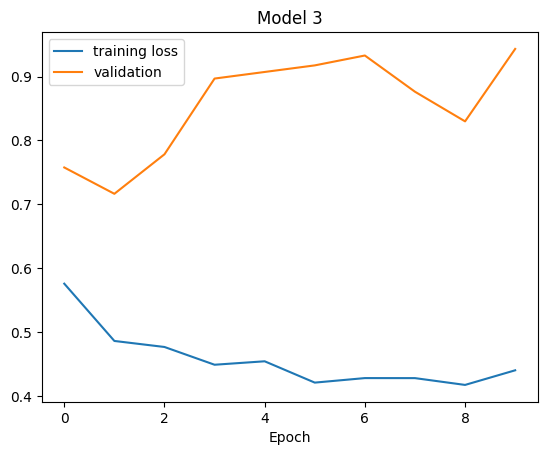

In [25]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()
plt.title("Model 3")

In [26]:
model_3.load_state_dict(torch.load(best_model_path))
_ = model_3.eval()

<ipython-input-26-ca4d8e97e492>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3.load_state_dict(torch.load(best_model_path))


# 8. Check classifications

Loop over validation files, and plot a confusion matrix so we get a feeling for how we're doing!

100%|██████████| 20/20 [00:03<00:00,  5.60it/s]


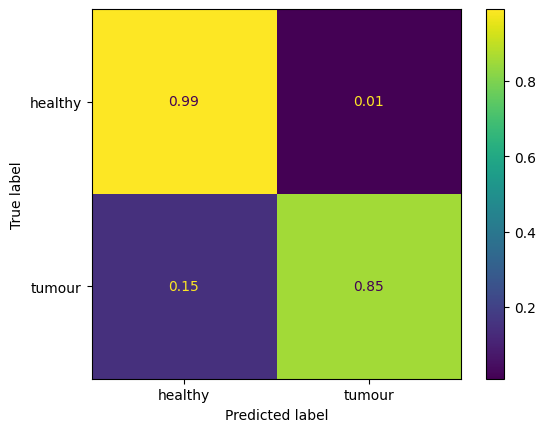

In [27]:
# Confusion Matrix Model 1

y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model_1(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


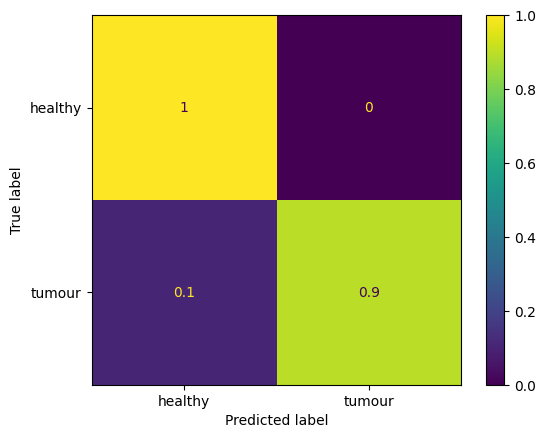

In [28]:
# Confusion Matrix Model 2

y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model_2(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


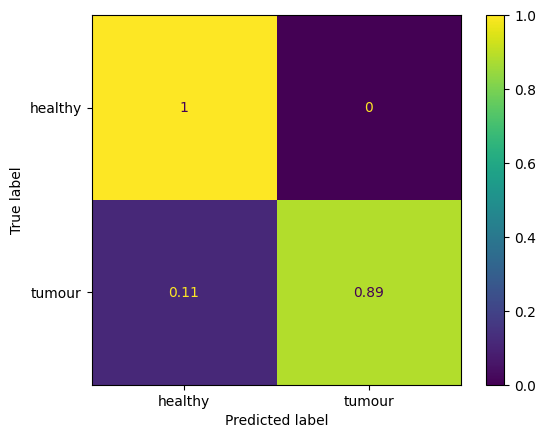

In [29]:
# Confusion Matrix Model 3

y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model_3(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])